<a href="https://colab.research.google.com/github/rahul94jh/Transfer-learning/blob/main/tensorflow_transfer_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is based on the tutorial at https://www.tensorflow.org/tutorials/images/transfer_learning and notebook hosted at https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb#scrollTo=19IQ2gqneqmS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data preprocessing

### Data download

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

68608000/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


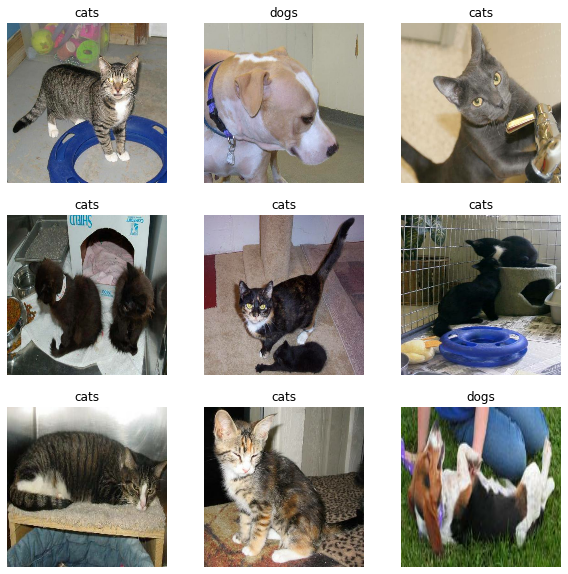

In [3]:
# get labels from the train dataset
class_names = train_dataset.class_names

# plot first
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Create test dataset

In [4]:
# We have 1000 total images in validation set and we set batch_size as 32 hence 32 total batch
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 32


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

# let's take 6 batches to test set
test_dataset = validation_dataset.take(val_batches // 5)

# skip the 6 batches which we have considered in test set and re define the validation set
validation_dataset = validation_dataset.skip(val_batches // 5)


In [6]:
# So out of 32 batches in validation set we considered 6 for test set hence 26 batches left for validation set
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [8]:
# This is active only during trainig remains in active during evaluate
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Testing Augmentation

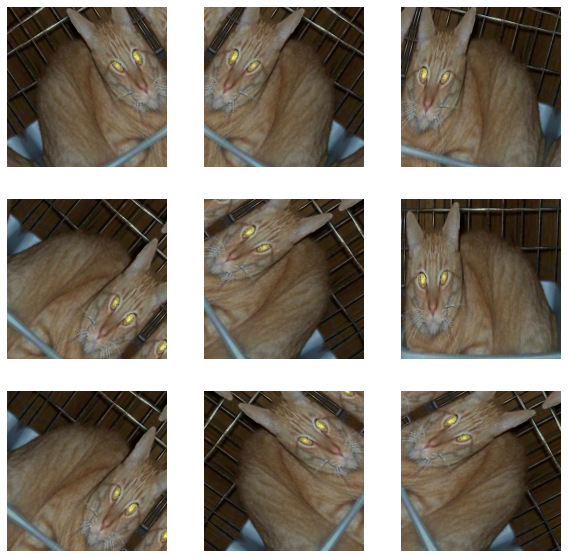

In [9]:
for image, _ in train_dataset.take(1):  # pick 1 batch
  plt.figure(figsize=(10, 10))
  first_image = image[0]  # pick first image from the batch
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) # apply augmentation
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescaling image

In [10]:
# Let's first check the pixel values range for the images 
import random
images=[]
for image, labels in train_dataset.take(1):
  images.append(image)

first_image = random.choice(images)
# check the pixels max and min values
np.max(first_image), np.min(first_image)



(255.0, 0.0)

We will be using MobileNetV2 pretrained model for training which expects the image pixels value in the range [-1,1] hence we will have to re scale our images which have the range [0-255]

In [11]:
# This will automatically take care of rescaling 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# we could also use Rescaling layer to rescale pixel values from [0,255] to [-1, 1]
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1) # [(255 / 127.5) + offset] and [(0/127.5) + offset]

# Build base model using pretrained MobileNet V2

In [12]:
# Add channel size to image shape
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE  

(160, 160, 3)

### Getting to know the pretrained model

In [13]:
# Let's initialize the base model without the classification head
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Let's have a look at model structure
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
________________

In [14]:
# we could print the layers name, input and out shape of the model
for layer in base_model.layers:
  print(f"name {layer.name} , input shape:  {layer.input_shape}, Output shape: {layer.output_shape}, Trainable: {layer.trainable}")

name input_1 , input shape:  [(None, 160, 160, 3)], Output shape: [(None, 160, 160, 3)], Trainable: True
name Conv1 , input shape:  (None, 160, 160, 3), Output shape: (None, 80, 80, 32), Trainable: True
name bn_Conv1 , input shape:  (None, 80, 80, 32), Output shape: (None, 80, 80, 32), Trainable: True
name Conv1_relu , input shape:  (None, 80, 80, 32), Output shape: (None, 80, 80, 32), Trainable: True
name expanded_conv_depthwise , input shape:  (None, 80, 80, 32), Output shape: (None, 80, 80, 32), Trainable: True
name expanded_conv_depthwise_BN , input shape:  (None, 80, 80, 32), Output shape: (None, 80, 80, 32), Trainable: True
name expanded_conv_depthwise_relu , input shape:  (None, 80, 80, 32), Output shape: (None, 80, 80, 32), Trainable: True
name expanded_conv_project , input shape:  (None, 80, 80, 32), Output shape: (None, 80, 80, 16), Trainable: True
name expanded_conv_project_BN , input shape:  (None, 80, 80, 16), Output shape: (None, 80, 80, 16), Trainable: True
name block_1_

In [15]:
# we could freeze (seting trainable to false) all the models layers iterating through the layers
for layer in base_model.layers:
  layer.trainable = False

In [16]:
# Now we could see that the Trainable params for the model is 0
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [17]:
# we could get layers by indexing 
print(base_model.layers[-3].name)

# We could also pick the layers based on its name
# The problem with this approach is, at different runs the name might change
print(base_model.get_layer('Conv_1').trainable)

Conv_1
False


In [18]:
# We could also choose which layers to train 
# We could decide to train some higher layers and leave the lower layers as non trainable

# lets set few top layers to be trainable using the index
for layer in base_model.layers[-3:-1]:
  print(layer.name)
  layer.trainable = True


Conv_1
Conv_1_bn


In [19]:
# Let's have a look on model internals again
# Now we could see we have Trainable params as 412,160 as we set to train the last conv layer above
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

There needs to have some precautions when setting trainable to false or true for the pretrained model as it could cause issue in model learnt weights, follow the guide at https://www.tensorflow.org/guide/keras/transfer_learning to learn more on it.

### Using Pretrained model for classification

In [20]:
# first let's freeze the layers
for layer in base_model.layers:
  layer.trainable = False

In [21]:
# Make sure the layers are freezed
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add Classification Head

The pretrained model we have loaded is without the classification head and we will add own classification head, but first we need to flatten the last layer which converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [22]:
# take a bbtch from the train set
image_batch, label_batch = next(iter(train_dataset))

print(image_batch.shape)
# Pass through the base model which acts as feature extractor without classification head
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 160, 160, 3)
(32, 5, 5, 1280)


In [23]:
# Let's use GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [24]:
# Lets add Dense layer to convert these features into a single prediction per image (Binary classification)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Building the model

In [25]:
inputs = tf.keras.Input(shape=(IMG_SHAPE))   # prepare the input
X = data_augmentation(inputs)  # perform augmentation
X = preprocess_input(X)  # rescaling the pixels
X = base_model(X, training=False)  # pass to pretrained model
X = global_average_layer(X)  # apply global average pooling to flatten the output from pretrained model
X = tf.keras.layers.Dropout(0.2)(X) # add dropout
outputs = prediction_layer(X)  # apply prediction layer

model = tf.keras.Model(inputs, outputs)  # bild new model based on above architecture
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

### Compiling the model

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# So we have 1,281 trainable paremeters
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

# Train and evaluate the model

In [28]:
initial_epochs = 10

# Let's evaluate the model performance without training it first
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 18s 602ms/step - loss: 0.9919 - accuracy: 0.4669


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.00
initial accuracy: 0.47


In [30]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 64s 967ms/step - loss: 0.7914 - accuracy: 0.5325 - val_loss: 0.6041 - val_accuracy: 0.6782
Epoch 2/10
63/63 [==============================] - 61s 962ms/step - loss: 0.5741 - accuracy: 0.6870 - val_loss: 0.4415 - val_accuracy: 0.8267
Epoch 3/10
63/63 [==============================] - 60s 955ms/step - loss: 0.4581 - accuracy: 0.7515 - val_loss: 0.3366 - val_accuracy: 0.8812
Epoch 4/10
63/63 [==============================] - 61s 958ms/step - loss: 0.3843 - accuracy: 0.8220 - val_loss: 0.2790 - val_accuracy: 0.9084
Epoch 5/10
63/63 [==============================] - 61s 969ms/step - loss: 0.3360 - accuracy: 0.8490 - val_loss: 0.2278 - val_accuracy: 0.9245
Epoch 6/10
63/63 [==============================] - 62s 979ms/step - loss: 0.2933 - accuracy: 0.8700 - val_loss: 0.2074 - val_accuracy: 0.9282
Epoch 7/10
63/63 [==============================] - 62s 975ms/step - loss: 0.2722 - accuracy: 0.8800 - val_loss: 0.1843 - val_accuracy: 0.9356

### Learning curves

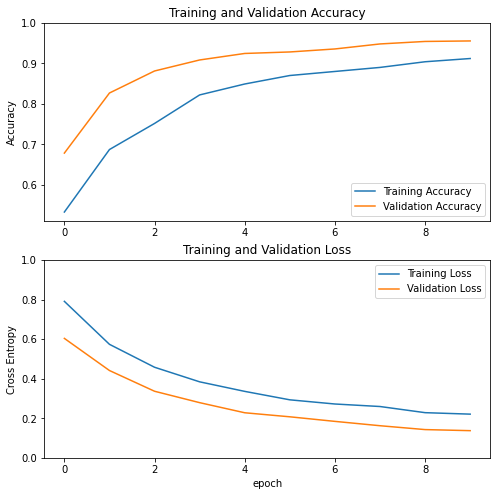

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

# Fine Tuning

The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-Freeze top layers of the base model

In [36]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [37]:
# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
base_model.summary()

### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [39]:
len(model.trainable_variables)

26

In [ ]:
# As we have unfreezed some layers of base model, we could see now we have lot more trainable parameter
model.summary()

### Continue training the model

In [41]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 60s 954ms/step - loss: 0.2192 - accuracy: 0.9015 - val_loss: 0.1361 - val_accuracy: 0.9530
Epoch 11/20
63/63 [==============================] - 61s 969ms/step - loss: 0.2053 - accuracy: 0.9125 - val_loss: 0.1183 - val_accuracy: 0.9616
Epoch 12/20
63/63 [==============================] - 60s 951ms/step - loss: 0.1946 - accuracy: 0.9180 - val_loss: 0.1138 - val_accuracy: 0.9641
Epoch 13/20
63/63 [==============================] - 60s 950ms/step - loss: 0.1987 - accuracy: 0.9180 - val_loss: 0.1140 - val_accuracy: 0.9616
Epoch 14/20
63/63 [==============================] - 61s 961ms/step - loss: 0.1868 - accuracy: 0.9180 - val_loss: 0.1049 - val_accuracy: 0.9629
Epoch 15/20
63/63 [==============================] - 61s 957ms/step - loss: 0.1854 - accuracy: 0.9200 - val_loss: 0.1022 - val_accuracy: 0.9629
Epoch 16/20
63/63 [==============================] - 60s 956ms/step - loss: 0.1784 - accuracy: 0.9220 - val_loss: 0.1018 - val_accuracy:

In [42]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

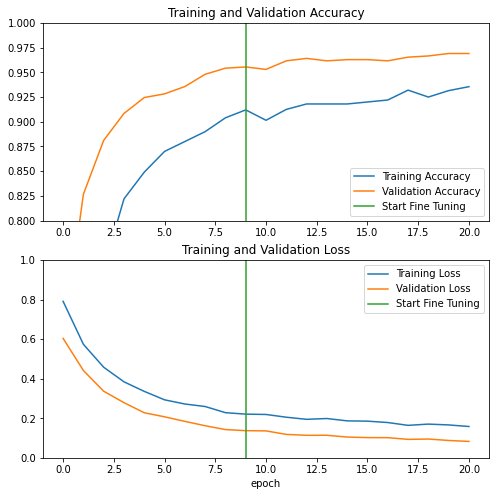

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation and prediction

In [44]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 4s 617ms/step - loss: 0.0873 - accuracy: 0.9740
Test accuracy : 0.9739583134651184


Predictions:
 [1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1]
Labels:
 [1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1]


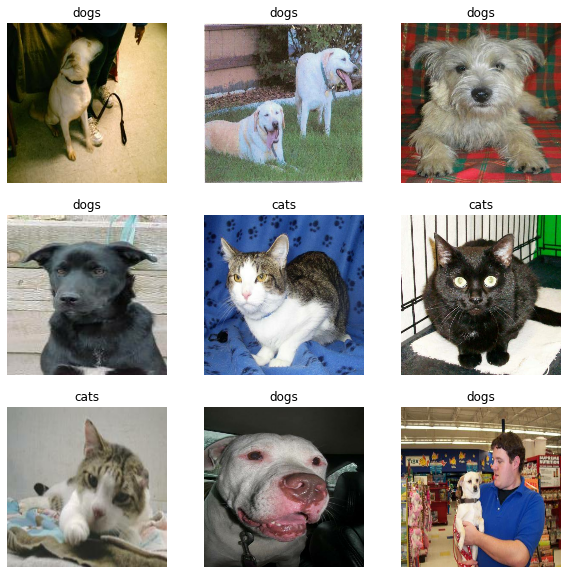

In [45]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")